In [78]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [79]:
data_file_name = "output_file.csv"

In [80]:
# Veriyi data frame nesnesi olarak içeri aktarıyoruz
base_df = pd.read_csv(data_file_name, encoding='utf-8')
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46234 entries, 0 to 46233
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Yıl                46234 non-null  int64  
 1   Model              46234 non-null  int64  
 2   Renk               46234 non-null  int64  
 3   Boya-değişen       46234 non-null  float64
 4   Çekiş              46234 non-null  float64
 5   Arka Tampon        46234 non-null  float64
 6   Sağ Ön Çamurluk    46234 non-null  float64
 7   Sol Ön Çamurluk    46234 non-null  float64
 8   Kilometre          46234 non-null  int64  
 9   Fiyat              46234 non-null  int64  
 10  Marka              46234 non-null  int64  
 11  Yakıt Tipi         46234 non-null  float64
 12  Vites Tipi         46234 non-null  float64
 13  Kasa Tipi          46234 non-null  float64
 14  Ön Tampon          46234 non-null  float64
 15  Arka Kaput         46234 non-null  float64
 16  Sol Arka Kapı      462

In [81]:
useful_df = base_df.drop(['_id'], axis=1)

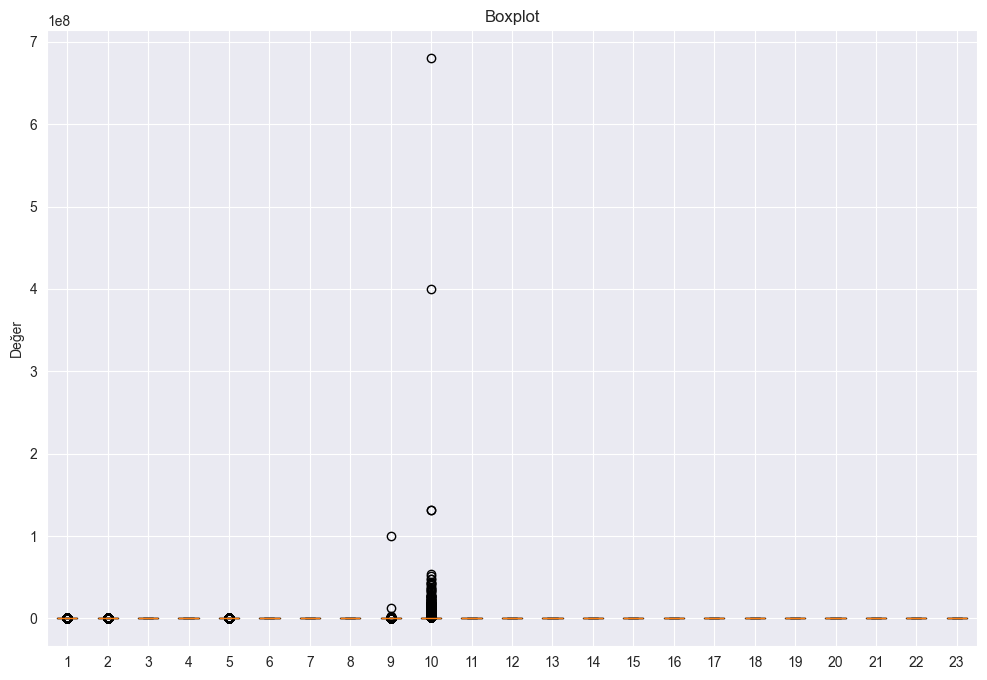

In [82]:
plt.figure(figsize=(12, 8))
plt.boxplot(useful_df)
plt.title('Boxplot')
plt.ylabel('Değer')
plt.show()

In [83]:
# Çeyreklerin hesaplanması
Q1 = useful_df["Fiyat"].quantile(0.25)
Q3 = useful_df["Fiyat"].quantile(0.75)

# IQR'nin hesaplanması
IQR = Q3 - Q1

# Aykırı değerlerin tanımlanması
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Aykırı değerlerin belirlenmesi
outliers = useful_df["Fiyat"][(useful_df["Fiyat"] < lower_bound) | (useful_df["Fiyat"] > upper_bound)]

print("Aykırı Değerler:")
print(outliers)

ready_to_train = useful_df.drop(outliers.index)
ready_to_train.reset_index(drop=True, inplace=True)


Aykırı Değerler:
33       1865900
41       1670000
57       2350000
83       1650000
88       1485750
          ...   
46078    2450000
46081    1520000
46082    1636000
46171    1679000
46200    1785000
Name: Fiyat, Length: 2632, dtype: int64


In [84]:
X = ready_to_train.drop("Fiyat", axis = 1)
y = ready_to_train["Fiyat"]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 12
                                                    )

scaler_X_test = MinMaxScaler() # bu minmaxscaler işlemi sadece yapay sinir ağı eğitiminde kullanmak için var
scaler_X_train = MinMaxScaler() # yapay sinir ağına vermek için verilerin normalize edilmiş versiyonunu saklıyorum

scaled_X_test = pd.DataFrame(scaler_X_test.fit_transform(X_test), columns=X.columns)
scaled_X_train = pd.DataFrame(scaler_X_train.fit_transform(X_train), columns=X.columns)

In [85]:
# XGBoost regresyon model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [86]:
train_predictions_xgb = model_xgb.predict(X_train)
test_predictions_xgb = model_xgb.predict(X_test)
train_rmse_xgb = mean_squared_error(y_train, train_predictions_xgb, squared=False)
test_rmse_xgb = mean_squared_error(y_test, test_predictions_xgb, squared=False)

print("Eğitim RMSE:", train_rmse_xgb)
print("Test RMSE:", test_rmse_xgb)

Eğitim RMSE: 58673.79487324612
Test RMSE: 74912.82035960842


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


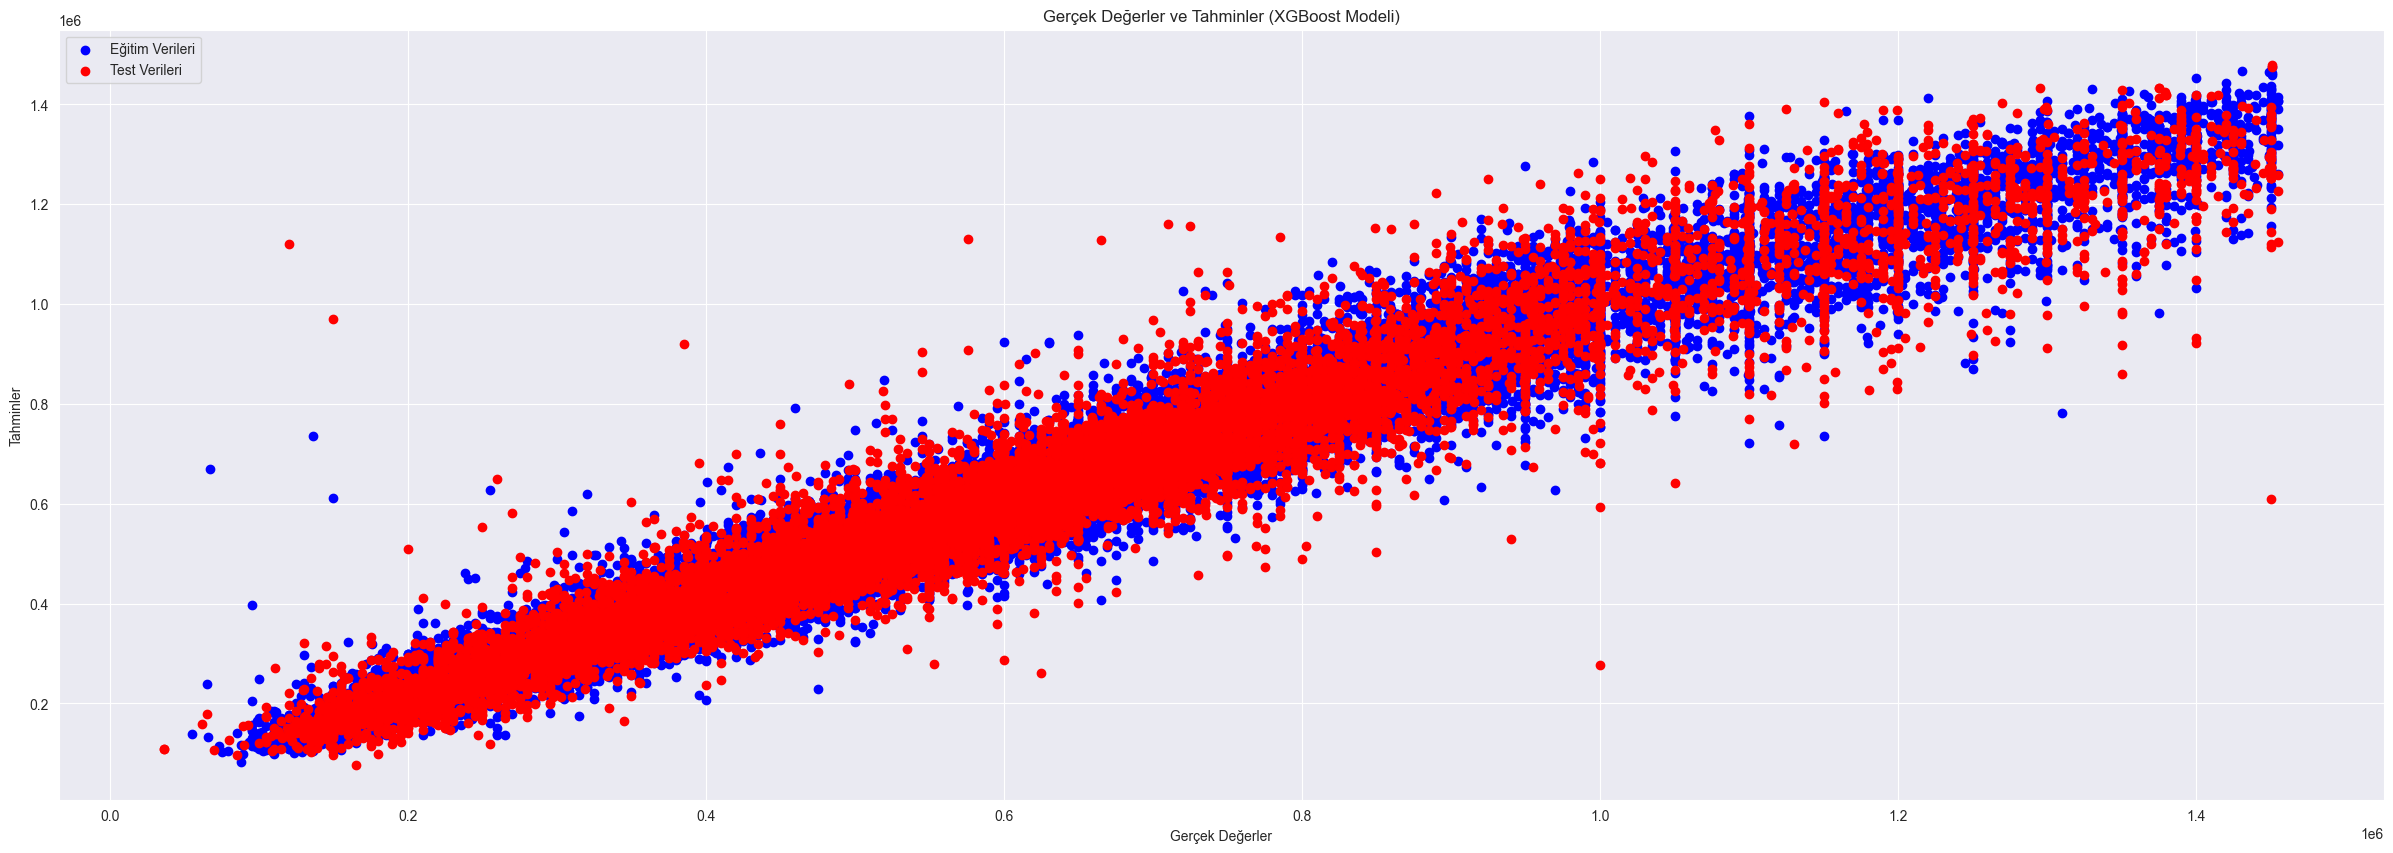

In [87]:
plt.figure(figsize=(30, 10))

plt.scatter(y_train, train_predictions_xgb, color='blue', label='Eğitim Verileri')
plt.scatter(y_test, test_predictions_xgb, color='red', label='Test Verileri')

plt.title('Gerçek Değerler ve Tahminler (XGBoost Modeli)')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahminler')
plt.legend()

plt.show()

In [88]:
# RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
train_predictions_rf = model_rf.predict(X_train)
test_predictions_rf = model_rf.predict(X_test)
train_rmse_rf = mean_squared_error(y_train, train_predictions_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test, test_predictions_rf, squared=False)

print("Eğitim RMSE:", train_rmse_rf)
print("Test RMSE:", test_rmse_rf)

Eğitim RMSE: 29320.652527286402
Test RMSE: 77129.60025143337


/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/berkfatihturan/Desktop/bft/Projects/Python/dataRe/venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
